# Black–Scholes Implied Volatility Surface
This notebook walks through the complete workflow of loading option quotes, computing Black–Scholes implied volatilities, reshaping them into a surface, and visualizing the results. Each step is self-contained and heavily commented so it can serve as both documentation and a reusable analysis template.

## 1. Imports and global configuration

In [37]:
%matplotlib inline

# Core scientific stack
import math
from math import exp, log, sqrt

import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection side effects)
from scipy.optimize import brentq

# Global plotting and display parameters
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 6)
np.set_printoptions(precision=6, suppress=True)
pd.options.display.float_format = lambda x: f"{x:,.6f}"

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Load option CSV

In [38]:
# Path to the CSV exported by download_options.py.
TICKER = "SPY"  # Change this ticker to target another options_<TICKER>.csv file.
CSV_PATH = f"options_{TICKER}.csv"

# Read the dataset and perform quick sanity checks.
df = pd.read_csv(CSV_PATH)
required = {"S0", "K", "C_mkt", "T"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"CSV is missing required columns: {missing}")

# Optionally filter to calls when a 'type' column is provided.
if 'type' in df.columns:
    original_rows = len(df)
    df = df[df['type'].astype(str).str.upper() == 'C'].copy()
    print(f"Filtered to call options: {len(df)} / {original_rows} rows retained.")
    if df.empty:
        raise ValueError("Dataset contains no call rows after filtering.")
else:
    print("No 'type' column detected; assuming the CSV already contains only calls.")

print(f"Loaded {CSV_PATH} with shape {df.shape}.")
display(df.head())
print("Descriptive statistics:")
display(df.describe(include='all'))


Filtered to call options: 3970 / 7624 rows retained.
Loaded options_SPY.csv with shape (3970, 6).


,S0,K,C_mkt,T,type,iv
10,677.630127,400.000000,266.250000,0.000950,C,4.032232
17,677.630127,430.000000,248.860000,0.000950,C,3.569337
19,677.630127,435.000000,247.150000,0.000950,C,3.422853
31,677.630127,490.000000,195.250000,0.000950,C,2.627933
33,677.630127,495.000000,168.400000,0.000950,C,2.543949


Descriptive statistics:


,S0,K,C_mkt,T,type,iv
count,"3,970.000000","3,970.000000","3,970.000000","3,970.000000",3970,"3,970.000000"
unique,NaN,NaN,NaN,NaN,1,NaN
top,NaN,NaN,NaN,NaN,C,NaN
freq,NaN,NaN,NaN,NaN,3970,NaN
mean,677.630127,638.664232,91.794204,0.556452,NaN,0.311838
std,0.000000,172.046047,109.851423,0.647915,NaN,0.296211
min,677.630127,50.000000,0.010000,0.000950,NaN,0.000010
25%,677.630127,557.250000,7.000000,0.077662,NaN,0.161423
50%,677.630127,652.000000,50.065000,0.269443,NaN,0.232660
75%,677.630127,710.000000,132.965000,0.877662,NaN,0.362540


## 3. Black–Scholes helper functions

In [39]:
# --- Normal CDF -------------------------------------------------------
def normal_cdf(x: float) -> float:
    """Return Phi(x), the standard normal cumulative distribution function."""
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))


# --- Black-Scholes call price ----------------------------------------
def bs_call(S0: float, K: float, T: float, r: float, q: float, vol: float) -> float:
    """Price a European call with the classic Black-Scholes closed form."""
    if T <= 0:
        # At expiry we fall back to intrinsic value discounted appropriately.
        return max(S0 * math.exp(-q * T) - K * math.exp(-r * T), 0.0)
    vol = max(vol, 1e-10)  # Numerical guard to avoid division by zero.
    sqrt_T = math.sqrt(T)
    d1 = (math.log(S0 / K) + (r - q + 0.5 * vol * vol) * T) / (vol * sqrt_T)
    d2 = d1 - vol * sqrt_T
    discount_domestic = math.exp(-r * T)
    discount_foreign = math.exp(-q * T)
    price = S0 * discount_foreign * normal_cdf(d1) - K * discount_domestic * normal_cdf(d2)
    return price


# --- Implied volatility solver ---------------------------------------
def implied_vol_bs(C_mkt: float, S0: float, K: float, T: float, r: float, q: float = 0.0) -> float:
    """Invert the Black-Scholes formula via a safeguarded Brent search."""
    # Guardrails: handle degenerate maturities or absurd prices early.
    if T <= 0 or C_mkt <= 0:
        return float("nan")

    # Intrinsic value bound: if the market price violates it, exit gracefully.
    intrinsic = max(S0 * math.exp(-q * T) - K * math.exp(-r * T), 0.0)
    if C_mkt < intrinsic - 1e-8:
        return float("nan")

    # Objective for root finding: price(vol) - market price.
    def objective(vol: float) -> float:
        return bs_call(S0, K, T, r, q, vol) - C_mkt

    vol_low, vol_high = 1e-4, 0.5  # Sensible starting bracket.
    price_high = bs_call(S0, K, T, r, q, vol_high)
    # Expand the upper bracket until we dominate the market price or hit a cap.
    while price_high < C_mkt and vol_high < 10.0:
        vol_high *= 2.0
        price_high = bs_call(S0, K, T, r, q, vol_high)

    if price_high < C_mkt:
        return float("nan")

    try:
        return brentq(objective, vol_low, vol_high, xtol=1e-8, rtol=1e-8, maxiter=200)
    except ValueError:
        return float("nan")

## 4. Compute implied volatility column

In [40]:
# Constant short rate used throughout the analysis. Adjust here if needed.
risk_free_rate = 0.02
dividend_yield = 0.0

sigmas = []
for idx, row in df.iterrows():
    sigma = implied_vol_bs(row["C_mkt"], row["S0"], row["K"], row["T"], risk_free_rate, dividend_yield)
    sigmas.append(sigma)

df["sigma_BS"] = sigmas
print("Implied volatilities computed.")
display(df.head())

print("Sigma summary statistics:")
display(df["sigma_BS"].describe())

print("Missing values per column (post-sigma computation):")
display(df.isna().sum())

Implied volatilities computed.


,S0,K,C_mkt,T,type,iv,sigma_BS
10,677.630127,400.000000,266.250000,0.000950,C,4.032232,NaN
17,677.630127,430.000000,248.860000,0.000950,C,3.569337,7.574627
19,677.630127,435.000000,247.150000,0.000950,C,3.422853,9.515370
31,677.630127,490.000000,195.250000,0.000950,C,2.627933,8.443855
33,677.630127,495.000000,168.400000,0.000950,C,2.543949,NaN


Sigma summary statistics:


count   3,359.000000
mean        0.328352
std         0.490464
min         0.104851
25%         0.156540
50%         0.209539
75%         0.312189
max         9.515370
Name: sigma_BS, dtype: float64

Missing values per column (post-sigma computation):


S0            0
K             0
C_mkt         0
T             0
type          0
iv            0
sigma_BS    611
dtype: int64

## 5. Reshape into surface grids

In [41]:
# Compute moneyness S0/K for each quote.
df["moneyness"] = df["S0"] / df["K"]

# Sorted grids for strikes, maturities, and moneyness.
K_grid = np.sort(df["K"].unique())
T_grid = np.sort(df["T"].unique())
m_grid = np.sort(df["moneyness"].unique())

# Pivot tables for different visualizations.
sigma_surface_m = df.pivot_table(index="T", columns="moneyness", values="sigma_BS")
sigma_surface_k = df.pivot_table(index="T", columns="K", values="sigma_BS")

print("Surface matrix (rows = T, columns = moneyness):")
display(sigma_surface_m.head())

print("Surface matrix (rows = T, columns = strikes K):")
display(sigma_surface_k.head())

Surface matrix (rows = T, columns = moneyness):


moneyness,0.505694,0.509496,0.513356,0.517275,0.521254,0.525295,0.529399,0.533567,0.537802,0.542104,...,2.710521,3.011689,3.080137,3.151768,3.226810,3.388151,3.566474,3.986060,4.517534,11.293835
T,,,,,,,,,,,,,,,,,,,,,
0.000950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.009169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.011909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.014649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.017388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Surface matrix (rows = T, columns = strikes K):


K,60.000000,150.000000,170.000000,190.000000,200.000000,210.000000,215.000000,220.000000,225.000000,250.000000,...,"1,250.000000","1,260.000000","1,270.000000","1,280.000000","1,290.000000","1,300.000000","1,310.000000","1,320.000000","1,330.000000","1,340.000000"
T,,,,,,,,,,,,,,,,,,,,,
0.000950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.009169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.011909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.014649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.017388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 6. Plot implied volatility surfaces

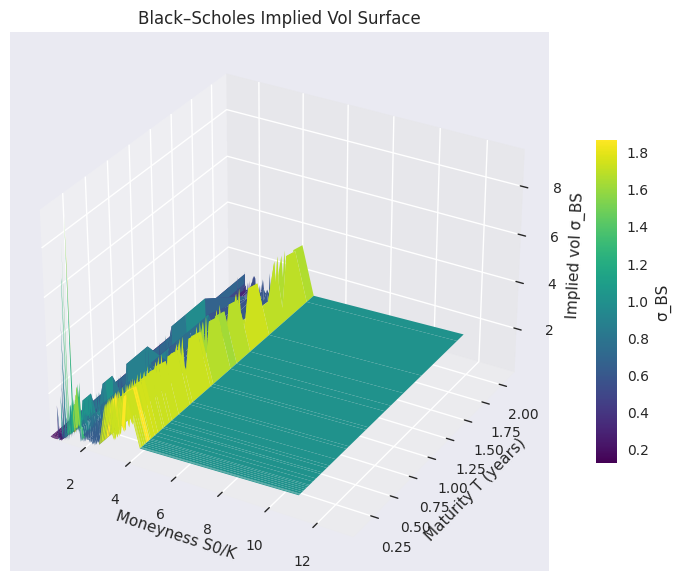

In [42]:
# --- 3D surface: moneyness vs maturity vs implied vol ----------------
T_vals = sigma_surface_m.index.values
M_vals = sigma_surface_m.columns.values
TT, MM = np.meshgrid(T_vals, M_vals, indexing="ij")
ZZ = sigma_surface_m.values

# Replace NaNs with the column mean to keep the surface continuous.
Z_filled = np.array(ZZ, copy=True)
col_means = np.nanmean(Z_filled, axis=0)
inds = np.where(np.isnan(Z_filled))
if inds[0].size > 0:
    Z_filled[inds] = np.take(col_means, inds[1])

# Axis bounds derived from the CSV (min/max of each dimension).
m_min = float(df["moneyness"].min())
m_max = float(df["moneyness"].max())
t_min = float(df["T"].min())
t_max = float(df["T"].max())
sigma_min = float(np.nanmin(df["sigma_BS"].values))
sigma_max = float(np.nanmax(df["sigma_BS"].values))

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(MM, TT, Z_filled, cmap=cm.viridis, edgecolor="none")
ax.set_title("Black–Scholes Implied Vol Surface")
ax.set_xlabel("Moneyness S0/K")
ax.set_ylabel("Maturity T (years)")
ax.set_zlabel("Implied vol σ_BS")
ax.set_xlim(m_min, m_max)
ax.set_ylim(t_min, t_max)
ax.set_zlim(sigma_min, sigma_max)
fig.colorbar(surf, shrink=0.6, aspect=15, label="σ_BS")
plt.show()


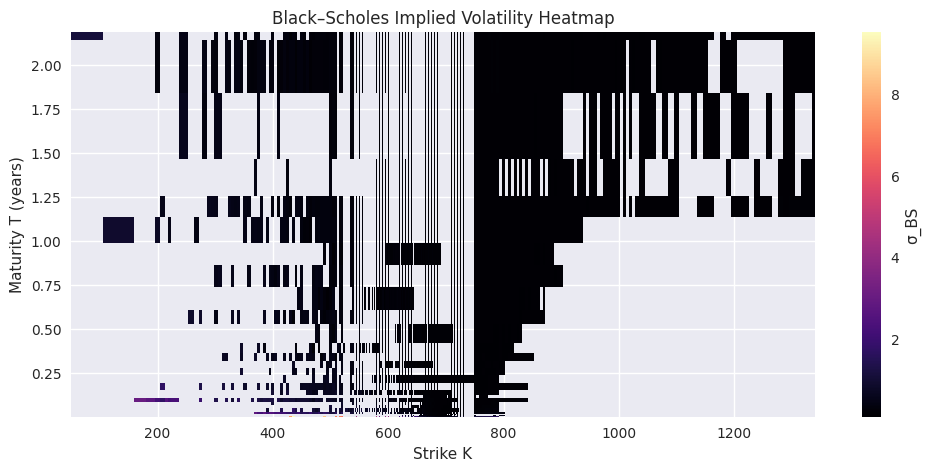

In [43]:
# --- 2D heatmap: strikes vs maturity ---------------------------------
T_vals_k = sigma_surface_k.index.values
K_vals = sigma_surface_k.columns.values
K_mesh, T_mesh = np.meshgrid(K_vals, T_vals_k)
ZK = sigma_surface_k.values

k_min = float(df["K"].min())
k_max = float(df["K"].max())
t_min = float(df["T"].min())
t_max = float(df["T"].max())
sigma_min = float(np.nanmin(df["sigma_BS"].values))
sigma_max = float(np.nanmax(df["sigma_BS"].values))

fig, ax = plt.subplots(figsize=(12, 5))
cmap_plot = ax.pcolormesh(K_mesh, T_mesh, ZK, shading="auto", cmap=cm.magma, vmin=sigma_min, vmax=sigma_max)
ax.set_title("Black–Scholes Implied Volatility Heatmap")
ax.set_xlabel("Strike K")
ax.set_ylabel("Maturity T (years)")
ax.set_xlim(k_min, k_max)
ax.set_ylim(t_min, t_max)
fig.colorbar(cmap_plot, ax=ax, label="σ_BS")
plt.show()


In [44]:
# --- Interactive Plotly surface mirroring the Matplotlib view -----------
Z_plot = np.array(sigma_surface_k.values, dtype=float)
# Fill NaNs column-wise to avoid holes in the surface.
if np.isnan(Z_plot).any():
    col_means = np.nanmean(Z_plot, axis=0)
    inds = np.where(np.isnan(Z_plot))
    if inds[0].size > 0:
        Z_plot[inds] = np.take(col_means, inds[1])

fig = go.Figure(data=[
    go.Surface(
        x=K_mesh,
        y=T_mesh,
        z=Z_plot,
        colorscale="Viridis",
        showscale=True,
    )
])
fig.update_layout(
    title=f"Interactive Implied Volatility Surface ({TICKER})",
    scene=dict(
        xaxis_title="Strike K",
        yaxis_title="Maturity T (years)",
        zaxis_title="Implied vol σ_BS",
        xaxis=dict(range=[float(df["K"].min()), float(df["K"].max())]),
        yaxis=dict(range=[float(df["T"].min()), float(df["T"].max())]),
        zaxis=dict(range=[float(np.nanmin(df["sigma_BS"].values)), float(np.nanmax(df["sigma_BS"].values))]),
        camera=dict(eye=dict(x=1.6, y=1.4, z=1.2)),
    ),
    template="plotly_dark",
    width=900,
    height=600,
)
fig.show()


## 7. Optional diagnostics

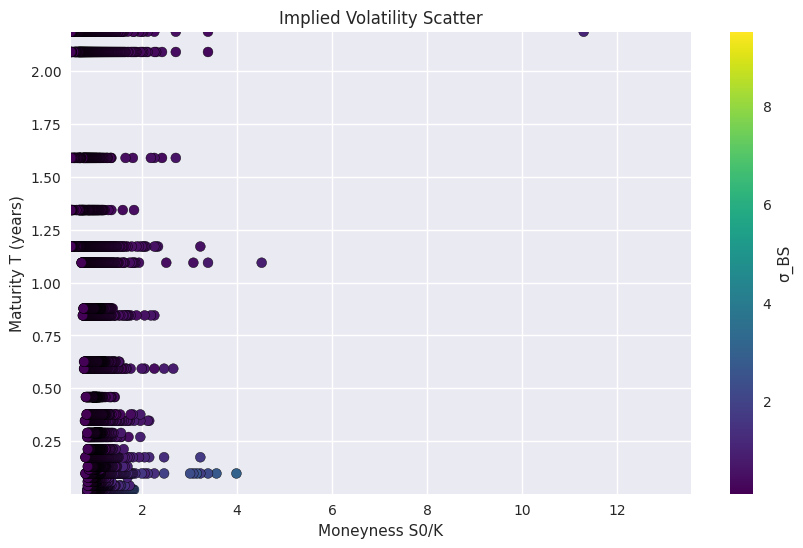

Detected 45 potential σ outliers (3-sigma rule).
        S0          K        T  sigma_BS
677.630127 430.000000 0.000950  7.574627
677.630127 435.000000 0.000950  9.515370
677.630127 490.000000 0.000950  8.443855
677.630127 510.000000 0.000950  7.205751
677.630127 515.000000 0.000950  7.018000
677.630127 520.000000 0.000950  6.861543
677.630127 530.000000 0.000950  7.200367
677.630127 545.000000 0.000950  4.233518
677.630127 565.000000 0.000950  5.221420
677.630127 570.000000 0.000950  3.816925
677.630127 575.000000 0.000950  3.426083
677.630127 580.000000 0.000950  4.587611
677.630127 585.000000 0.000950  3.160372
677.630127 595.000000 0.000950  4.083456
677.630127 600.000000 0.000950  3.784780
677.630127 605.000000 0.000950  2.784073
677.630127 610.000000 0.000950  3.571146
677.630127 615.000000 0.000950  3.477082
677.630127 620.000000 0.000950  2.063323
677.630127 625.000000 0.000950  2.614490
677.630127 645.000000 0.000950  2.038356
677.630127 646.000000 0.000950  2.103641
677.6301

In [45]:
# Scatter plot of (moneyness, maturity) colored by implied vol.
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(df["moneyness"], df["T"], c=df["sigma_BS"], cmap=cm.viridis, s=50, edgecolor="k")
ax.set_title("Implied Volatility Scatter")
ax.set_xlabel("Moneyness S0/K")
ax.set_ylabel("Maturity T (years)")
ax.set_xlim(float(df["moneyness"].min()), float(df["moneyness"].max()))
ax.set_ylim(float(df["T"].min()), float(df["T"].max()))
fig.colorbar(scatter, ax=ax, label="σ_BS")
plt.show()

# Simple outlier detection based on a symmetric 3-sigma rule.
sigma_mean = df["sigma_BS"].mean()
sigma_std = df["sigma_BS"].std()
upper_cut = sigma_mean + 3 * sigma_std
lower_cut = max(sigma_mean - 3 * sigma_std, 0.0)
outliers = df[(df["sigma_BS"] > upper_cut) | (df["sigma_BS"] < lower_cut)]

print(f"Detected {len(outliers)} potential σ outliers (3-sigma rule).")
if not outliers.empty:
    print(outliers[["S0", "K", "T", "sigma_BS"]].to_string(index=False))
else:
    print("No extreme implied vols found.")


In [46]:
from massive import RESTClient

client = RESTClient("lQ_78z3ZYIkl0ZjcYPnyMH3Q9VM_WfZG")

contracts = []
for c in client.list_options_contracts(
	underlying_ticker="AAPL",
	contract_type="call",
	expiration_date="2026-11-13",
	strike_price=275,
	expired="true",
	order="asc",
	limit=1000,
	sort="ticker",
	):
    contracts.append(c)

print(contracts)

    



    

[]


## 8. Takeaways
The implied volatility surface above summarises how option prices embed expectations about future variance. Higher moneyness (deep ITM calls) usually compresses σ, while deep OTM regions inflate it; maturity adds term-structure effects where long expiries smooth short-term spikes. Always keep in mind that market noise, sparse strike/maturity grids, and the Black–Scholes framework itself (constant volatility, no jumps) limit the precision of this reconstruction, so further modelling such as local or stochastic volatility is often warranted.